<a href="https://colab.research.google.com/github/bochendong/car_racing/blob/main/%E2%80%9Cdsn_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Global Enviorment Settings

In [2]:
!git clone https://github.com/bochendong/car_racing.git

Cloning into 'car_racing'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 120 (delta 66), reused 35 (delta 15), pack-reused 0
Receiving objects: 100% (120/120), 1.14 MiB | 8.55 MiB/s, done.
Resolving deltas: 100% (66/66), done.


In [3]:
%%capture
!sudo apt update && sudo apt install python-opengl
!sudo apt update && sudo apt install xvfb
!pip install gym-notebook-wrapper stable-baselines[mpi] box2d box2d-kengz pyvirtualdisplay pyglet
!pip install wandb
!pip install gym==0.21.0
!pip install pyvirtualdisplay -qq
!pip install folium==0.2.1
!apt-get install -y xvfb python-opengl ffmpeg -qq
!pip install box2d

In [4]:
import numpy as np
import random

from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
from torch.distributions import Beta
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler

from torch.autograd import Function

import gnwrapper
import gym
from gym import logger as gymlogger
gymlogger.set_level(30)

from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
import wandb

%matplotlib inline
import matplotlib.pyplot as plt
import os
import glob

In [5]:
%cd car_racing
import car_racing as cr

/content/car_racing


In [6]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

if (os.path.exists("./output_r")) == False:
    os.mkdir("output_r")
    
for epoch in range (3000):
    files = glob.glob("./output_r/*.png")

    for f in files:
        os.remove(f)

cuda


# Car Racing Env Wrapper

In [7]:
class Env():
    def __init__(self, color, seed = 0):
        self.env = gnwrapper.Animation(cr.CarRacing(color = color))
        self.env = cr.CarRacing(color = color)
        self.color = color
        self.env.seed(seed)
        self.reward_threshold = 1000

    def reset(self):
        self.counter = 0
        self.av_r = self.reward_memory()

        self.die = False
        img_rgb = self.env.reset()
        img_rgb = img_rgb / 128. - 1
        self.stack = [img_rgb] * 4
        return np.array(self.stack)

    def step(self, action):
        total_reward = 0
        for i in range(8):
            img_rgb, reward, die, _ = self.env.step(action)

            if die: reward += 100

            if self.color == 'g' and np.mean(img_rgb[:, :, 1]) > 185.0:
                  reward -= 0.05

            total_reward += reward

            done = True if self.av_r(reward) <= -0.1 else False
            if done or die:
                break

        img_rgb = img_rgb / 128. - 1
        self.stack.pop(0)
        self.stack.append(img_rgb)
        assert len(self.stack) == 4
        return np.array(self.stack), total_reward, done, die

    def step_eval(self, action):
        img_rgb, reward, done, _ = self.env.step(action)

        img_rgb = img_rgb / 128. - 1
        self.stack.pop(0)
        self.stack.append(img_rgb)
        return np.array(self.stack), reward, done, _

    def render(self, *arg):
        self.env.render(*arg)

    @staticmethod
    def reward_memory():
        count = 0
        length = 100
        history = np.zeros(length)

        def memory(reward):
            nonlocal count
            history[count] = reward
            count = (count + 1) % length
            return np.mean(history)

        return memory

In [8]:
env_green = gnwrapper.Animation(cr.CarRacing())
env_green = cr.CarRacing(color = 'g')
obs = env_green.reset()

/usr/local/lib/python3.7/dist-packages/gym/spaces/box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float32
  "Box bound precision lowered by casting to {}".format(self.dtype)
/usr/local/lib/python3.7/dist-packages/gym/spaces/box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float32
  "Box bound precision lowered by casting to {}".format(self.dtype)


In [9]:
def get_random(state):
    red_scale, green_scale, blue_scale = 1., 1., 1.
    base_scale = 0.5
    while (red_scale == green_scale == blue_scale):
        add_green = random.randint(0, 1)
        add_red = random.randint(0, 1)
        add_blue = random.randint(0, 1)
        if (add_red): 
            red_scale = random.uniform(0.5, 1.1)
        if (add_green): 
            green_scale = random.uniform(0.5, 1.1)
        if (add_blue): 
            blue_scale = random.uniform(0.5, 1.1)
            
    for i in range (0, 4):
        s = torch.transpose(state[i], 0, 2)
        road = s [1] - s [0] * 0.6 - s[2] * 0.4
        road = torch.stack((road, road, road), 0)
        ones = torch.ones(3, 96, 96).to(device)

        road_mask = torch.logical_xor(road, ones)
        road_layer = s * road_mask

        light_green = 204 / 128. - 1
        light_green_mask = torch.logical_xor(s - light_green , ones)
        light_green_layer = s * light_green_mask

        dark_green = 230 / 128. - 1
        dark_green_mask = torch.logical_xor(s - dark_green , ones)
        dark_green_layer = s * dark_green_mask

        bg_layer = light_green_layer + dark_green_layer

        ones = torch.ones(96, 96).to(device)
        back_ground_mask = torch.logical_xor(bg_layer[1], ones)

        red_channel = (back_ground_mask * 128) /128. - 1
        green_channel = (back_ground_mask * 128) /128. - 1
        blue_channel = (back_ground_mask * 128) /128. - 1

        if (add_red): red_channel = bg_layer[1] * red_scale
        if (add_green): green_channel = bg_layer[1] * green_scale
        if (add_blue): blue_channel = bg_layer[1] * blue_scale

        new_bg_layer = torch.stack((red_channel, green_channel, blue_channel), 0)

        new_state = new_bg_layer + road_layer

        state[i] = torch.transpose(new_state, 0, 2)
        
    return state  

def get_random_buffer(buffer, batch_size):
    target_buffer = buffer.clone()
    for i in range (batch_size):
        target_buffer[i] = get_random(target_buffer[i])
    return target_buffer

# DSN Model

In [10]:
class ReverseLayerF(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha
        return output, None  

class DSN(nn.Module):
    def __init__(self):
        super(DSN, self).__init__()
        
        self.sketch = nn.Sequential(
            nn.Conv3d(4, 4, kernel_size=(1, 1, 3), stride=1),
            nn.ReLU(),
        )

        self.source_encoder = nn.Sequential(
            nn.Conv2d(4, 8, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),
            nn.ReLU(),
        )
        
        self.target_encoder = nn.Sequential(
            nn.Conv2d(4, 8, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),
            nn.ReLU(),
        )

        self.shared_encoder = nn.Sequential(
            nn.Conv2d(4, 8, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 48, kernel_size=3, stride=2),
            nn.ReLU(),
        )

        self.source_fc = nn.Sequential(
            nn.Linear(in_features = 64 * 5 * 5, out_features = 512),
            nn.ReLU(True)
            )
        
        self.target_fc = nn.Sequential(
            nn.Linear(in_features = 64 * 5 * 5, out_features=512),
            nn.ReLU(True)
            )
        
        self.shared_fc = nn.Sequential(
            nn.Linear(in_features= 48 * 5 * 5, out_features=512),
            nn.ReLU(True)
            )
        
        self.pred_domain = nn.Sequential(
            nn.Linear(in_features=512, out_features=128),
            nn.ReLU(True),
            nn.Linear(in_features=128, out_features=2)
        )
        self.shared_decoder_fc = nn.Sequential(nn.Linear(in_features=512, out_features=64 * 5 * 5))

        self.shared_decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 4, 4, stride=2),
            nn.ReLU(True),
        )

        self.shared_decoder_expand = nn.Sequential(
            nn.ConvTranspose3d(4, 4, kernel_size = (1, 1, 3), stride=1),
            nn.Tanh()
        )

        self.v = nn.Sequential(nn.Linear(512, 100), nn.ReLU(), nn.Linear(100, 1))
        self.fc = nn.Sequential(nn.Linear(512, 100), nn.ReLU())
        self.alpha_head = nn.Sequential(nn.Linear(100, 3), nn.Softplus())
        self.beta_head = nn.Sequential(nn.Linear(100, 3), nn.Softplus())
        self.apply(self._weights_init)

    def forward(self, input, get_v = False, input_type = "Source", eta = 0.1):
        sketch = self.sketch(input)
        sketch = torch.squeeze(sketch)
        # Shared
        shared_encode = self.shared_encoder(sketch)
        shared_encode = shared_encode.view(-1, 48 * 5 * 5)
        shared_encode = self.shared_fc(shared_encode)

        if (get_v): return self.v(shared_encode)

        # Private
        if (input_type == "Source" or input_type == "S"):
            private_encode = self.source_encoder(sketch)
            private_encode = private_encode.view(-1, 64 * 5 * 5)
            private_encode = self.source_fc(private_encode)

            v = self.v(shared_encode)
            out = self.fc(shared_encode)
            alpha = self.alpha_head(out) + 1
            beta = self.beta_head(out) + 1
        else:
            private_encode = self.target_encoder(sketch)
            private_encode = private_encode.view(-1, 64 * 5 * 5)
            private_encode = self.target_fc(private_encode)

        # Domain
        reversed_shared_code = ReverseLayerF.apply(shared_encode, eta)
        domain_label = self.pred_domain(reversed_shared_code)

        # Decoder
        rec_vec = self.shared_decoder_fc(private_encode + shared_encode)
        rec_vec = rec_vec.view(-1, 64, 5, 5)
        rec_code = self.shared_decoder_conv(rec_vec)
        rec_code = rec_code.unsqueeze(-1)
        rec_code = self.shared_decoder_expand(rec_code)

        if (input_type == "Source" or input_type == "S"):
            return (alpha, beta), v, domain_label, rec_code, shared_encode, private_encode
        else:
            return domain_label, rec_code, shared_encode, private_encode

    @staticmethod
    def _weights_init(m):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
            nn.init.constant_(m.bias, 0.1)

# Loss Functions

In [11]:
class MSE(nn.Module):
    def __init__(self):
        super(MSE, self).__init__()

    def forward(self, pred, real):
        diffs = torch.add(real, -pred)
        n = torch.numel(diffs.data)
        mse = torch.sum(diffs.pow(2)) / n

        return mse


class SIMSE(nn.Module):

    def __init__(self):
        super(SIMSE, self).__init__()

    def forward(self, pred, real):
        diffs = torch.add(real, - pred)
        n = torch.numel(diffs.data)
        simse = torch.sum(diffs).pow(2) / (n ** 2)

        return simse


class DiffLoss(nn.Module):

    def __init__(self):
        super(DiffLoss, self).__init__()

    def forward(self, input1, input2):

        batch_size = input1.size(0)
        input1 = input1.view(batch_size, -1)
        input2 = input2.view(batch_size, -1)

        input1_l2_norm = torch.norm(input1, p=2, dim=1, keepdim=True).detach()
        input1_l2 = input1.div(input1_l2_norm.expand_as(input1) + 1e-6)

        input2_l2_norm = torch.norm(input2, p=2, dim=1, keepdim=True).detach()
        input2_l2 = input2.div(input2_l2_norm.expand_as(input2) + 1e-6)

        diff_loss = torch.mean((input1_l2.t().mm(input2_l2)).pow(2))

        return diff_loss

In [12]:
loss_classification = torch.nn.CrossEntropyLoss().cuda()
loss_recon1 = MSE()
loss_recon2 = SIMSE()
loss_diff = DiffLoss()
loss_similarity = torch.nn.CrossEntropyLoss().cuda()

# Agent

In [13]:
class Agent():
    max_grad_norm = 0.5
    clip_param = 0.1
    ppo_epoch = 10
    alpha_weight = 0.01
    beta_weight = 0.075
    gamma_weight = 0.5

    transition = np.dtype([('s', np.float64, (4, 96, 96, 3)), ('a', np.float64, (3,)), ('a_logp', np.float64),
                            ('r', np.float64), ('s_', np.float64, (4, 96, 96, 3))])
    
    def __init__(self, net, criterion, optimizer, buffer_capacity = 2048, batch_size = 128):
        self.net = net
        self.buffer_capacity = buffer_capacity
        self.batch_size = batch_size
        self.criterion = criterion
        self.optimizer = optimizer

        self.source_buffer = np.empty(self.buffer_capacity, dtype=self.transition)
        self.counter = 0

    def select_action(self, state):
        state = torch.from_numpy(state).double().to(device).unsqueeze(0)
        with torch.no_grad():
            alpha, beta = self.net(state)[0]

        dist = Beta(alpha, beta)
        action = dist.sample()
        a_logp = dist.log_prob(action).sum(dim=1)

        action = action.squeeze().cpu().numpy()
        a_logp = a_logp.item()
        return action, a_logp

    def store(self, transition):
        self.source_buffer[self.counter] = transition
        self.counter += 1
        if self.counter == self.buffer_capacity:
            self.counter = 0
            return True

        return False

    def get_batch(self):
        return self.source_buffer

    def update(self, epoch, eta = 0.1):
        s = torch.tensor(self.source_buffer['s'], dtype=torch.double).to(device)
        a = torch.tensor(self.source_buffer['a'], dtype=torch.double).to(device)
        r = torch.tensor(self.source_buffer['r'], dtype=torch.double).to(device).view(-1, 1)
        s_ = torch.tensor(self.source_buffer['s_'], dtype=torch.double).to(device)
        old_a_logp = torch.tensor(self.source_buffer['a_logp'], dtype=torch.double).to(device).view(-1, 1)

        source_domain_label = torch.zeros(self.batch_size).long()
        target_domain_label = torch.ones(self.batch_size).long()
        source_domain_label = source_domain_label.to(device)
        target_domain_label = target_domain_label.to(device)

        with torch.no_grad():
            target_v = r + 0.99 * self.net(s_, get_v = True)
            adv = target_v - self.net(s, get_v = True)

        image_array = []
        source_acc_array, target_acc_array = [], []
        s_loss, t_loss = [0, 0], [0, 0]
        for _ in range(self.ppo_epoch):
            total = 0
            source_domain_correct, target_domain_correct = 0, 0
            add_image = True
            for index in BatchSampler(SubsetRandomSampler(range(self.buffer_capacity)), self.batch_size, True):
                total += self.batch_size
                # Source
                (alpha, beta), v, domain_label, rec_code_s, shared_encode, private_encode = self.net(s[index], eta = eta)
                _, predicted = torch.max(domain_label.data, 1)
                source_domain_correct += predicted.eq(source_domain_label.data).cpu().sum().item()

                # PPO update
                dist = Beta(alpha, beta)
                a_logp = dist.log_prob(a[index]).sum(dim=1, keepdim=True)
                ratio = torch.exp(a_logp - old_a_logp[index])
                surr1 = ratio * adv[index]
                surr2 = torch.clamp(ratio, 1.0 - self.clip_param, 1.0 + self.clip_param) * adv[index]

                # Loss
                similarity_loss = self.gamma_weight * loss_similarity(domain_label, source_domain_label)
                recon_loss_1 = self.alpha_weight * loss_recon1(rec_code_s, s[index])
                recon_loss_2 = self.alpha_weight * loss_recon2(rec_code_s, s[index])
                action_loss = -torch.min(surr1, surr2).mean()
                value_loss = F.smooth_l1_loss(v, target_v[index])

                loss = action_loss + 2. * value_loss + similarity_loss + recon_loss_1 + recon_loss_2
                self.net.zero_grad()
                loss.backward()
                self.optimizer.step()

                s_loss[0] += recon_loss_1.cpu().detach().numpy()
                s_loss[1] += recon_loss_2.cpu().detach().numpy()

                # Target
                with torch.no_grad():
                    target_batch = get_random_buffer(s[index], self.batch_size)

                domain_label, rec_code_t, shared_encode, private_encode = self.net(target_batch, input_type = "Target", eta = eta)
                _, predicted = torch.max(domain_label.data, 1)
                target_domain_correct += predicted.eq(target_domain_label.data).cpu().sum().item()
                # Loss
                similarity_loss = self.gamma_weight * loss_similarity(domain_label, target_domain_label)
                recon_loss_1 = self.alpha_weight * loss_recon1(rec_code_t, s[index])
                recon_loss_2 = self.alpha_weight * loss_recon2(rec_code_t, s[index])


                loss = similarity_loss + recon_loss_1 + recon_loss_2
                self.net.zero_grad()
                loss.backward()
                self.optimizer.step()

                t_loss[0] += recon_loss_1.cpu().detach().numpy()
                t_loss[1] += recon_loss_2.cpu().detach().numpy()

                if (add_image):
                    image = s[index][0][0].reshape(96, 96, 3)
                    image = (image + 1) / 2
                    image = image.cpu().detach().numpy()
                    image_array.append(image)
                
                    image = target_batch[0][0].reshape(96, 96, 3)
                    image = (image + 1) / 2
                    image = image.cpu().detach().numpy()
                    image_array.append(image)

                    image = rec_code_s[0][0].reshape(96, 96, 3)
                    image = (image + 1) / 2
                    image = image.cpu().detach().numpy()
                    image_array.append(image)
                
                    image = rec_code_t[0][0].reshape(96, 96, 3)
                    image = (image + 1) / 2
                    image = image.cpu().detach().numpy()
                    image_array.append(image)
                    
                    add_image = False

            source_acc_array.append( source_domain_correct / total )
            target_acc_array.append( target_domain_correct / total )

        source_acc_mean, target_acc_mean = 0, 0
        for acc in source_acc_array: source_acc_mean += acc
        for acc in target_acc_array: target_acc_mean += acc
            
        f, axs = plt.subplots(10, 4, figsize = (16, 30))
        for j in range (0, 10):
            for i in range (0, 4):
              if (i == 0): axs[j][i].set_title("Source")
              elif (i == 1): axs[j][i].set_title("Target")
              elif (i == 2): axs[j][i].set_title("Source Recon")
              elif (i == 3): axs[j][i].set_title("Target Recon")
        axs = axs.flatten()
        for img, ax in zip(image_array, axs):
            ax.imshow(img)
        f.savefig('./output_r/Recon_image_%04d.png' % epoch)
        plt.close(f)
        
        return source_acc_mean / 10 , target_acc_mean / 10, s_loss, t_loss

# Agent Trainig

In [13]:
def eval(agent, env):
    score = 0
    state = env.reset()

    for t in range(1000):
        action, a_logp = agent.select_action(state)

        state_, reward, done, _ = env.step_eval(action * np.array([2., 1., 1.]) + np.array([-1., 0., 0.]))

        score += reward

        state = state_

        if done:
            break

    return score

In [14]:
def train(source_env, target_env, agent):
    training_records= []
    running_score_records = []
    running_score = 0
    
    c1_running_score, c2_running_score = 0, 0
    c1_training_records, c2_training_records = [], []
    c1_running_score_records, c2_running_score_records = [], []

    s_acc_lst, t_acc_lst = [], []
    s_recon_loss_1_lst, t_recon_loss_1_lst = [], []
    s_recon_loss_2_lst, t_recon_loss_2_lst = [], []

    eta = 0.1
    for i_ep in range(3000):
        score = 0
        state = source_env.reset()

        for t in range(1000):
            action, a_logp = agent.select_action(state)
            state_, reward, done, die = source_env.step(action * np.array([2., 1., 1.])\
                                                              + np.array([-1., 0., 0.]))
            score += reward

            should_update = agent.store((state, action, a_logp, reward, state_))

            if should_update: 
                if (i_ep < 500): eta_max =  1.0
                elif (i_ep < 1500): eta_max = 0.9
                else: eta_max = 0.7
                    
                print("eta: %.2f" % eta)
                s_acc, t_acc, s_loss, t_loss = agent.update(epoch = i_ep, eta = eta) 
                s_acc_lst.append(s_acc)
                t_acc_lst.append(t_acc)
                s_recon_loss_1_lst.append(s_loss[0])
                t_recon_loss_1_lst.append(t_loss[0])
                s_recon_loss_2_lst.append(s_loss[1])
                t_recon_loss_2_lst.append(t_loss[1])

                f, axs = plt.subplots(3, 1, figsize = (18, 8))
                axs[0].plot(range(len(s_acc_lst)), s_acc_lst)
                axs[0].plot(range(len(t_acc_lst)), t_acc_lst)
                axs[0].legend(['Source', 'Target'])
                axs[0].set_title("Domain Acc")

                axs[1].plot(range(len(s_recon_loss_1_lst)), s_recon_loss_1_lst)
                axs[1].plot(range(len(t_recon_loss_1_lst)), t_recon_loss_1_lst)
                axs[1].legend(['Source', 'Target'])
                axs[1].set_title("Recon 1")

                axs[2].plot(range(len(s_recon_loss_2_lst)), s_recon_loss_2_lst)
                axs[2].plot(range(len(t_recon_loss_2_lst)), t_recon_loss_2_lst)
                axs[2].legend(['Source', 'Target'])
                axs[2].set_title("Recon 2")

                f.savefig('./output_r/loss_%04d.png' % i_ep)
                plt.close(f)
                
            state = state_

            if done or die: break
                
        training_records.append(score)
        running_score = running_score * 0.99 + score * 0.01
        running_score_records.append(running_score)
        
        c1_score = eval(agent, target_env[0])
        c2_score = eval(agent, target_env[1])
        c1_training_records.append(c1_score)
        c2_training_records.append(c2_score)
        
        c1_running_score = c1_running_score * 0.99 + c1_score * 0.01
        c2_running_score = c2_running_score * 0.99 + c2_score * 0.01
        c1_running_score_records.append(c1_running_score)
        c2_running_score_records.append(c2_running_score)
        
        if (i_ep % 20 == 0):
            print('Ep {}\tLast score: {:.2f}\tMoving average score: {:.2f}'.format(i_ep, score, running_score))
            print('c1 score: {:.2f}\t c1 Moving average: {:.2f}'.format(c1_score, c1_running_score))
            print('c2 score: {:.2f}\t c2 Moving average: {:.2f}'.format(c2_score, c2_running_score))
            
            if (i_ep != 0):
                f, axs = plt.subplots(1, 2, figsize = (16, 8))
                axs[0].plot(range(len(training_records)), training_records)
                axs[1].plot(range(len(running_score_records)), running_score_records)
                axs[0].plot(range(len(c1_training_records)), c1_training_records)
                axs[1].plot(range(len(c1_running_score_records)), c1_running_score_records)
                axs[0].plot(range(len(c2_training_records)), c2_training_records)
                axs[1].plot(range(len(c2_running_score_records)), c2_running_score_records)

                axs[0].legend(['Source', 'Env c1', 'Env c2'])
                axs[0].set_title("Scores")
                axs[1].legend(['Source', 'Env c1', 'Env c2'])
                axs[1].set_title("Average Score")

                f.savefig('./output_r/scores_%04d.png' % i_ep)
                plt.close(f)

In [ ]:
green_env = Env(color = 'g', seed = 0)
env_c1 = Env(color = 'c1', seed = 0)
env_c2 = Env(color = 'c2', seed = 0)

criterion = nn.CrossEntropyLoss().cuda()
net = DSN().double().cuda()
optimizer = optim.Adam(net.parameters(), lr=1e-3)
agent = Agent(net = net,  criterion = criterion,  optimizer = optimizer, buffer_capacity = 2048, batch_size = 128)

source_env = green_env
target_env = [env_c1, env_c2]
train(green_env, target_env, agent)

/usr/local/lib/python3.7/dist-packages/gym/spaces/box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float32
  "Box bound precision lowered by casting to {}".format(self.dtype)


Ep 0	Last score: -17.81	Moving average score: -0.18
c1 score: -22.82	 c1 Moving average: -0.23
c2 score: -22.82	 c2 Moving average: -0.23
retry to generate track (normal if there are not manyinstances of this message)
retry to generate track (normal if there are not manyinstances of this message)
retry to generate track (normal if there are not manyinstances of this message)
eta: 0.10
retry to generate track (normal if there are not manyinstances of this message)
retry to generate track (normal if there are not manyinstances of this message)
retry to generate track (normal if there are not manyinstances of this message)
Ep 20	Last score: -20.23	Moving average score: -3.10
c1 score: -32.26	 c1 Moving average: -4.64
c2 score: -32.26	 c2 Moving average: -4.75
eta: 0.10
retry to generate track (normal if there are not manyinstances of this message)
retry to generate track (normal if there are not manyinstances of this message)
retry to generate track (normal if there are not manyinstances 

In [14]:
def get_batch(source_env, agent):
    for i_ep in range(3000):
        state = source_env.reset()
        for t in range(1000):
            action, a_logp = agent.select_action(state)
            state_, reward, done, die = source_env.step(action * np.array([2., 1., 1.])\
                                                              + np.array([-1., 0., 0.]))

            should_update = agent.store((state, action, a_logp, reward, state_))
            if should_update: 
                return agent.get_batch()

            state = state_
            if done or die: break


In [15]:
green_env = Env(color = 'g', seed = 0)
criterion = nn.CrossEntropyLoss().cuda()
net = DSN().double().cuda()
optimizer = optim.Adam(net.parameters(), lr=1e-3)
agent = Agent(net = net,  criterion = criterion,  optimizer = optimizer, buffer_capacity = 2048, batch_size = 128)

batch = get_batch(green_env, agent)

/usr/local/lib/python3.7/dist-packages/gym/spaces/box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float32
  "Box bound precision lowered by casting to {}".format(self.dtype)


retry to generate track (normal if there are not manyinstances of this message)
retry to generate track (normal if there are not manyinstances of this message)


In [16]:
s = torch.tensor(batch['s'], dtype=torch.double).to(device)

state = s[10][0]
state.size()

torch.Size([96, 96, 3])

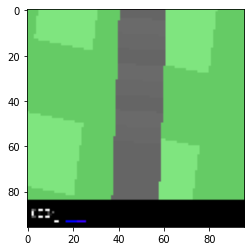

In [34]:
def show_state (state):
    image = (state + 1) / 2
    image = image.cpu().detach().numpy()
    plt.imshow(image)

show_state(state)

In [1]:
def get_road_layer(state):
    s = torch.transpose(state, 0, 2)
    road = s [1] - s [0] * 0.6 - s[2] * 0.4
    road = torch.stack((road, road, road), 0)
    ones = torch.ones(3, 96, 96).to(device)

    road_mask = torch.logical_xor(road, ones)
    road_layer = s * road_mask

    state = torch.transpose(road_layer, 0, 2)
        
    show_state (state)

# get_road_layer(state)

def get_red_block_layer():
    s = torch.zeros(3, 96, 96).to(device)

    red_block_0 = torch.zeros(3, 96, 96).to(device)

    for i in range(80, 96):
        for j in range(80, 96):
            red_block_0[0][i][j] = 255
    state = torch.transpose(red_block_0, 0, 2)

    show_state (state)

get_red_block_layer()

NameError: ignored

In [ ]:
def get_random(state):
    red_scale, green_scale, blue_scale = 1., 1., 1.
    base_scale = 0.5
    while (red_scale == green_scale == blue_scale):
        add_green = random.randint(0, 1)
        add_red = random.randint(0, 1)
        add_blue = random.randint(0, 1)
        if (add_red): 
            red_scale = random.uniform(0.5, 1.1)
        if (add_green): 
            green_scale = random.uniform(0.5, 1.1)
        if (add_blue): 
            blue_scale = random.uniform(0.5, 1.1)
            
    for i in range (0, 4):
        s = torch.transpose(state[i], 0, 2)
        road = s [1] - s [0] * 0.6 - s[2] * 0.4
        road = torch.stack((road, road, road), 0)
        ones = torch.ones(3, 96, 96).to(device)

        road_mask = torch.logical_xor(road, ones)
        road_layer = s * road_mask

        light_green = 204 / 128. - 1
        light_green_mask = torch.logical_xor(s - light_green , ones)
        light_green_layer = s * light_green_mask

        dark_green = 230 / 128. - 1
        dark_green_mask = torch.logical_xor(s - dark_green , ones)
        dark_green_layer = s * dark_green_mask

        bg_layer = light_green_layer + dark_green_layer

        ones = torch.ones(96, 96).to(device)
        back_ground_mask = torch.logical_xor(bg_layer[1], ones)

        red_channel = (back_ground_mask * 128) /128. - 1
        green_channel = (back_ground_mask * 128) /128. - 1
        blue_channel = (back_ground_mask * 128) /128. - 1

        if (add_red): red_channel = bg_layer[1] * red_scale
        if (add_green): green_channel = bg_layer[1] * green_scale
        if (add_blue): blue_channel = bg_layer[1] * blue_scale

        new_bg_layer = torch.stack((red_channel, green_channel, blue_channel), 0)

        new_state = new_bg_layer + road_layer

        state[i] = torch.transpose(new_state, 0, 2)
        
    return state  

def get_random_buffer(buffer, batch_size):
    target_buffer = buffer.clone()
    for i in range (batch_size):
        target_buffer[i] = get_random(target_buffer[i])
    return target_buffer
